In [1]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\j\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [3]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sql, con=engine)

Informacie o clankoch + ich popularite

1. vznikli az po zaciatku monitoringu
2. sledovane su aspon dva tyzdne

In [4]:
monitored_articles = pd.sql('''
WITH cte_monitored_articles AS (SELECT url
                                FROM article_fb_engagement
                                GROUP BY url
                                HAVING date_part('day', now() - min(sync_date)) > 30
)
SELECT afe.*, art.published_at
FROM article_fb_engagement afe
         JOIN article art on afe.url = art.url
WHERE afe.url in (SELECT url FROM cte_monitored_articles)
  AND art.published_at > (SELECT min(mjrl.run_finished) FROM monitor_job_run_log mjrl)
ORDER BY afe.url, sync_date;
''')

monitored_articles.sync_date = monitored_articles.sync_date + pd.DateOffset(hours=2) # sync_date is in UTC and published_at is in UTC+2 (I hope)
monitored_articles = monitored_articles.drop(columns=['comment_plugin_count', 'id'])
monitored_articles['popularity'] = monitored_articles['reaction_count'] + monitored_articles['comment_count'] + monitored_articles['share_count']

In [5]:
# add artifical first row for every value where engagement = (0,0,0) and sync_date = published_at
_mart = monitored_articles
_mart = _mart.sort_values(by=['url', 'sync_date'])
_mart = _mart.groupby('url').first().reset_index()
_mart = _mart.drop_duplicates()

first_rows = []
for row in _mart.itertuples():
    first_rows.append([row.url, 0, 0, 0, row.published_at, row.published_at, 0, False])
    first_rows.append([row.url, row.reaction_count, row.comment_count, row.share_count, row.sync_date, row.published_at, row.popularity, False])
    
monitored_articles_art = monitored_articles.copy()
monitored_articles_art['real_observation'] = True
monitored_articles_art = pd.concat([monitored_articles_art, pd.DataFrame(first_rows, columns=monitored_articles_art.columns)], ignore_index=True)
monitored_articles_art = monitored_articles_art.sort_values(by=['url', 'sync_date', 'real_observation'])
monitored_articles_art['age_hours'] = (monitored_articles_art['sync_date'] - monitored_articles_art['published_at']).apply(lambda x: x.total_seconds() // 3600)

In [6]:
monitored_articles_art.head()

,url,reaction_count,comment_count,share_count,sync_date,published_at,popularity,real_observation,age_hours
887078,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 04:42:00.000000,2019-10-25 04:42:00,0,False,0.0
887079,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 19:06:19.449111,2019-10-25 04:42:00,0,False,14.0
0,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 19:06:19.449111,2019-10-25 04:42:00,0,True,14.0
1,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 21:06:30.132140,2019-10-25 04:42:00,0,True,16.0
2,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 23:06:40.932503,2019-10-25 04:42:00,0,True,18.0


In [7]:
def sample_articles(data, size, random_state=None):
    urls = pd.Series(monitored_articles_art.url.unique()).sample(n=size, random_state=random_state)
    return monitored_articles_art[monitored_articles_art.url.isin(urls)].copy()

def plot_engagement(data, yscale, extra_fgrid_args=None, extra_sns_args=None):
    if extra_fgrid_args is None:
        extra_fgrid_args = {}
    
    if extra_sns_args is None:
        extra_sns_args = {}

    min_time = 0
    fgrid = sns.relplot(data=data,
                x='age_hours', y='popularity',
                hue='url', style='real_observation', style_order=[True, False],
                kind='line', height=12, aspect=1,
                legend=False,
                **extra_sns_args)
    fgrid.set(xlim=(min_time, None))
    fgrid.set(**extra_fgrid_args)
    ax = fgrid.axes[0][0].set_yscale(**yscale)
    return fgrid

In [8]:
f'sledovanych url aspon 2 tyzdne je: {len(monitored_articles_art.url.unique())}'

'sledovanych url aspon 2 tyzdne je: 2221'

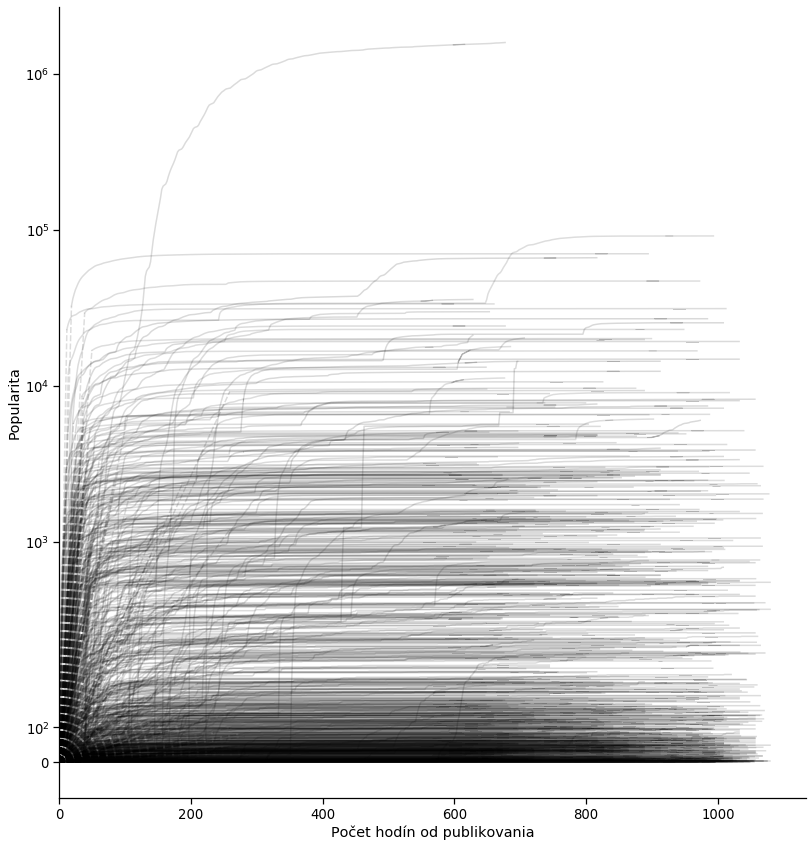

In [9]:
sample_size = 1000

sampled_articles = sample_articles(data=monitored_articles_art, size=sample_size, random_state=123)
palette = sns.dark_palette(color='black', n_colors=sample_size)

with sns.plotting_context("notebook", font_scale=1.2):
    eng_plot = plot_engagement(sampled_articles,
                        yscale={'value': 'symlog', 'linthreshy': 500},
                        extra_sns_args={'palette': palette, 'alpha': 0.15})

eng_plot.set_axis_labels('Počet hodín od publikovania', 'Popularita')

eng_plot.savefig('export/popularity-vyvoj.png')